# ADC 2024 starter notebook 

This baseline notebook is designed to offer a starting point for the competiters. Please note that the approach we've taken is not *THE* solution — it's simply ONE possible approach. Our aim is to assist participants in exploring different ways to preprocess and model the data. Please feel free to fork the notebook and save the model/data for your own exploration.



This notebook was prepared by Virginie Batista and Angèle Syty from the Institut d'Astrophysique de Paris, and Orphée Faucoz from Centre National d’Etudes Spatiales (CNES), with support from Gordon Yip and Tara Tahseen from University College London.

# READ THIS BEFORE YOU PROCEED
This training procedure uses the light dataset produced from this [notebook (Version 5)](https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data). We applied all the calibration steps EXCEPT Linearity Correction with Chunksize = 1. The binned dataset is available to download [here](https://www.kaggle.com/datasets/gordonyip/binned-dataset-v3/data). *If you want to carry out all the correction, you will have to do so yourself.*


**This notebook will only provide the model checkpoints, you are welcomed to use these checkpoints with your own script and submit to the leaderboard.** 

## Task overview

The challenge's primary objective is to process these exposures to produce a single, clean spectrum for each exoplanet, summarizing the rp/rs values across all wavelengths.

The exposure are subject to noises and the images or spectrum are not perfect. The Jitter noise has a complex signature that the ML model should recognize to produce a better spectra.

Different techniques are possible and are up to the participant imagination to produce a novel (and hopefully better) solution to this task.

Here outline our baseline approach :

We first fit  a 1D CNN to fit the mean value of the transmission spectra, taking as input the transit white curve (total flux of each image taken as a function of time).

For the second part of the baseline, to retrieve the atmopsheric features, we make the data lighter by summing up the fluxes along the y-axis, for each wavelength, resulting in 2D images of dimension (N_times, N_wavelengths). We also cut the signal to remove the out of transit in order to enhance transit depth variations between wavelengths. For the same reason, we substract the mean flux, corresponding to the average transit depth, to keep only wavelength variations around this mean. We use a 2D CNN to fit the atmospheric features. 


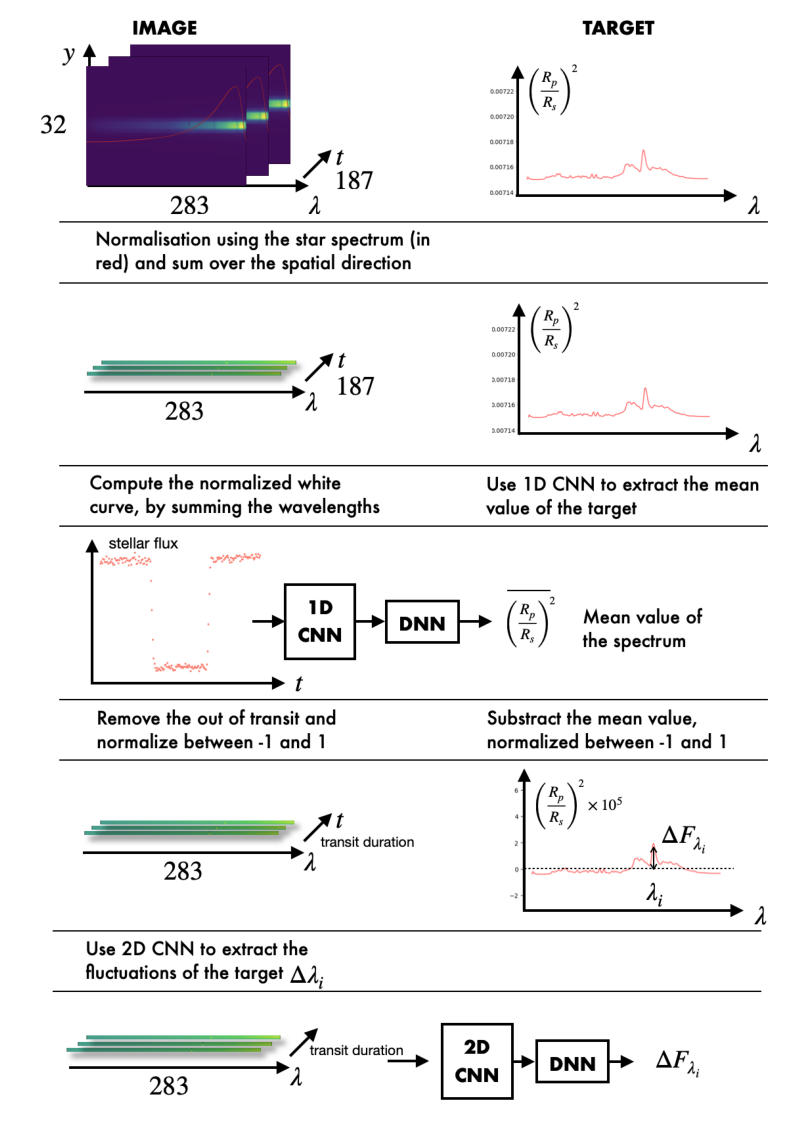

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('/kaggle/input/baseline-img/2nd_baseline.png')
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.axis('off') 
plt.show()

# Import library
<a id="import"></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf 
import random 
import os
from tensorflow.keras.losses import MeanAbsoluteError
from matplotlib.ticker import ScalarFormatter
import pandas as pd



2025-01-03 14:43:39.695081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 14:43:39.695174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 14:43:39.816351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setup Paths and Read Data

In [3]:
data_folder = '/kaggle/input/binned-dataset-v3/' # path to the folder containing the data
auxiliary_folder = '/kaggle/input/ariel-data-challenge-2024/' # path to the folder containing the train targets and wavelengths informations

In [4]:
data_train = np.load(f'{data_folder}/data_train.npy')
data_train_FGS = np.load(f'{data_folder}/data_train_FGS.npy')


We create a directory to save the outputs of this notebook, and define the hyperparameters of the model

In [5]:
output_dir = './output'

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ./output created.


# 1D-CNN for mean transit depth

## Preprocessing for 1D CNN

In [6]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)

targets = train_solution[:,1:]
targets_mean = targets[:,1:].mean(axis = 1) # used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve
N = targets.shape[0]
print(N)

673


We create the dataset by adding the FGS frame, crushed in one column, at the end of the AIRS data cube.  
The images are normalized using the star spectrum extracted from the images themselves.

In [7]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned  = data_train, data_train_FGS
FGS_column = signal_FGS_diff_transposed_binned.sum(axis = 2)
dataset = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)

we sum up the pixels on the y-axis to transform the data into 2D images

In [8]:
dataset = dataset.sum(axis=3)

We divide the images by the star flux assuming the first and last 50 instants belong to the out of transit. 

In [9]:
def create_dataset_norm(dataset1, dataset2) :
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2


def norm_star_spectrum (signal) : 
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    return signal/img_star[:,np.newaxis,:]

dataset_norm = norm_star_spectrum(dataset)
dataset_norm = np.transpose(dataset_norm,(0,2,1))


## Split the targets and observations between valid and train

We start by computing a "white curve", that is actually the sum of the signal over the all image, as a function of time. We split the data and normalize the train/valid/test data.

In [10]:
cut_inf, cut_sup = 39, 321 # we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
l = cut_sup - cut_inf + 1 
wls = np.arange(l)


def split (data, N) : 
    list_planets = np.arange(int(N * 0.7))
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets : 
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = N

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]
print(valid_obs.shape)

(202, 283, 187)


In [11]:
signal_AIRS_diff_transposed_binned = signal_AIRS_diff_transposed_binned.sum(axis=3)
wc_mean = signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
white_curve = signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]

def normalise_wlc(train, valid) :

    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)
    
    return train_norm, valid_norm

def normalize (train, valid) : 
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    return train_norm, valid_norm, min_train, max_train

# Split the light curves and targets 
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

# Normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets 
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)



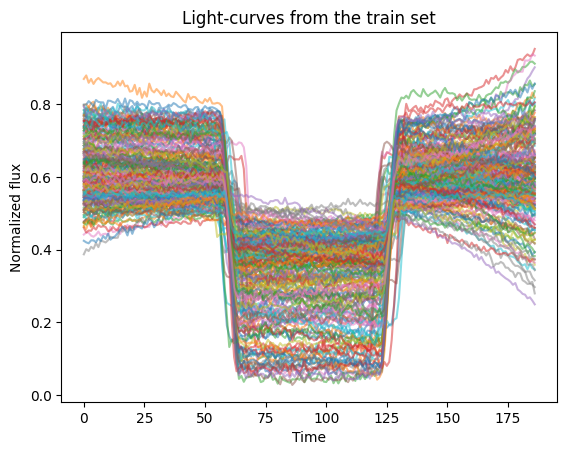

In [12]:
plt.figure()
for i in range (200) : 
    plt.plot(train_wc[-i], '-', alpha = 0.5)
plt.title('Light-curves from the train set') 
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

## Train 1D CNN
The model to estimate the mean of the target spectrum using the white light-curve is a 1D-CNN with Dropout layers to make a MC Dropout prediction.

In [13]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate,AveragePooling1D
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


input_wc = Input((187,1))
x = Conv1D(32, 3, activation='relu')(input_wc)
x = MaxPooling1D()(x)
x = BatchNormalization() (x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x, training = True)
output_wc = Dense(1, activation='linear')(x)

model_wc = Model(inputs=input_wc, outputs=output_wc)
model_wc.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 92, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 90, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,152,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,429 (5.08 MB)

 Trainable params: 1,332,365 (5.08 MB)

 Non-trainable params: 64 (256.00 B)

In [14]:
def scheduler(epoch, lr):
    decay_rate = 0.2
    decay_step = 200  
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

optimizer = SGD(0.001)
model_wc.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])
callback = LearningRateScheduler(scheduler)
checkpoint_filepath = 'output/model_1dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

print('Running ...')
history = model_wc.fit(
    x = train_wc,  
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),  
    batch_size=16,
    epochs= 500,
    shuffle=True,
    verbose=20, 
    callbacks=[model_ckt]
    )
print('Done.')



Running ...
Epoch 1/500


I0000 00:00:1735915492.994999     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1735915493.008542     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735915497.066588     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78/500
Epoch 7

## 1D CNN Inference

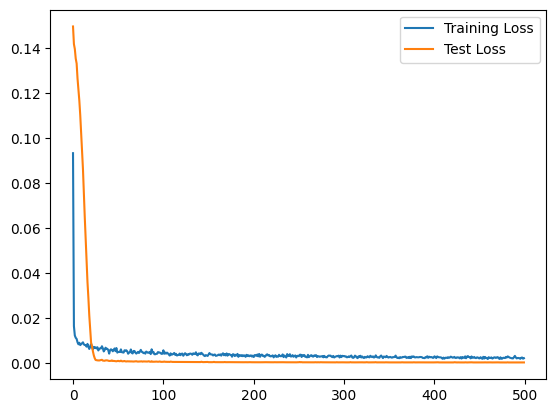

In [15]:
model_wc = load_model(checkpoint_filepath)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

Then, we perform the MC Dropout to obtain the mean prediction and the uncertainty associated. We choose to compute 1000 instances.

In [16]:
nb_dropout_wc = 1000

def unstandardizing (data, min_train_valid, max_train_valid) : 
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC (model, data, nb_dropout) : 
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) : 
        predictions[i,:] = model.predict(data, verbose = 0).flatten()
    return predictions

if do_the_mcdropout_wc :
    print('Running ...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc, spectre_valid_std_wc = spectre_valid_wc_all.mean(axis = 0), spectre_valid_wc_all.std(axis = 0)
    print('Done.')

else : 
    spectre_valid_wc = model_wc.predict(valid_wc).flatten()
    spectre_valid_wc = unstandardizing(spectre_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1*np.abs(spectre_valid_wc)

Running ...


W0000 00:00:1735915564.725674     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Done.


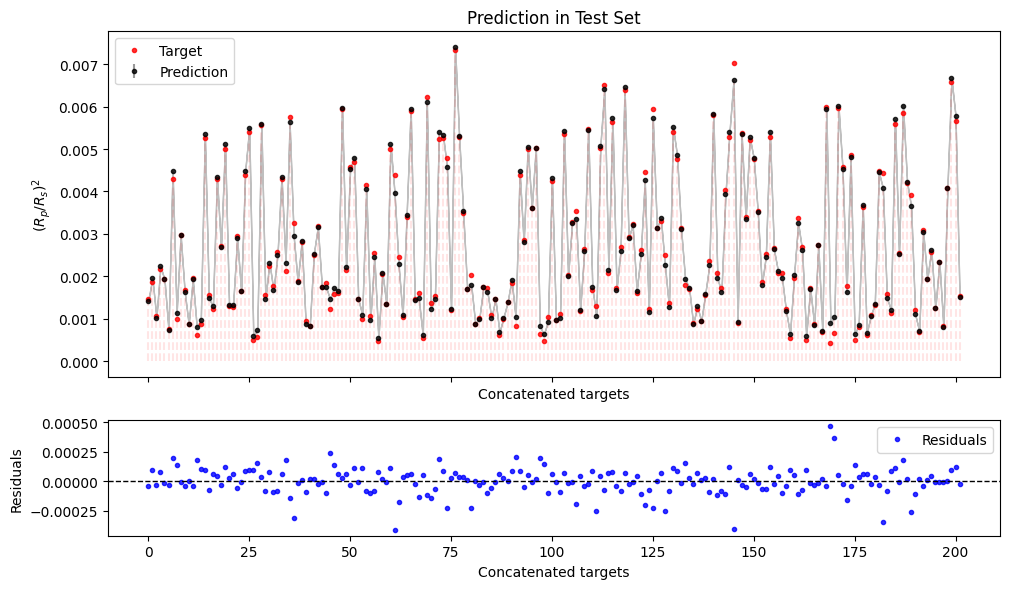

In [17]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction in Test Set')
ax1.legend()

ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()

plt.tight_layout()
plt.show()

In [18]:
residuals = valid_targets_wc - spectre_valid_wc
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  111.8252875578058 ppm


# 2D CNN for atmospheric features

<a id="fluctu"></a>
We now remove the mean value (transit depth) of the spectra to keep the atmospheric features only

## Preprocessing for 2D CNN

In [20]:
def suppress_mean(targets, mean) : 
    res = targets - np.repeat(mean.reshape((mean.shape[0], 1)), repeats = targets.shape[1], axis = 1)
    return res
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

train_targets_shift = suppress_mean(train_targets,  targets_mean[list_index_train])
valid_targets_shift = suppress_mean(valid_targets,  targets_mean[~list_index_train])

We normalize the targets so that they range between -1 and 1, centered on zero

In [21]:
##### normalization of the targets ###
def targets_normalization (data1, data2) : 
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max

def targets_norm_back (data, data_abs_max) : 
    return data * data_abs_max

train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(train_targets_shift, valid_targets_shift)

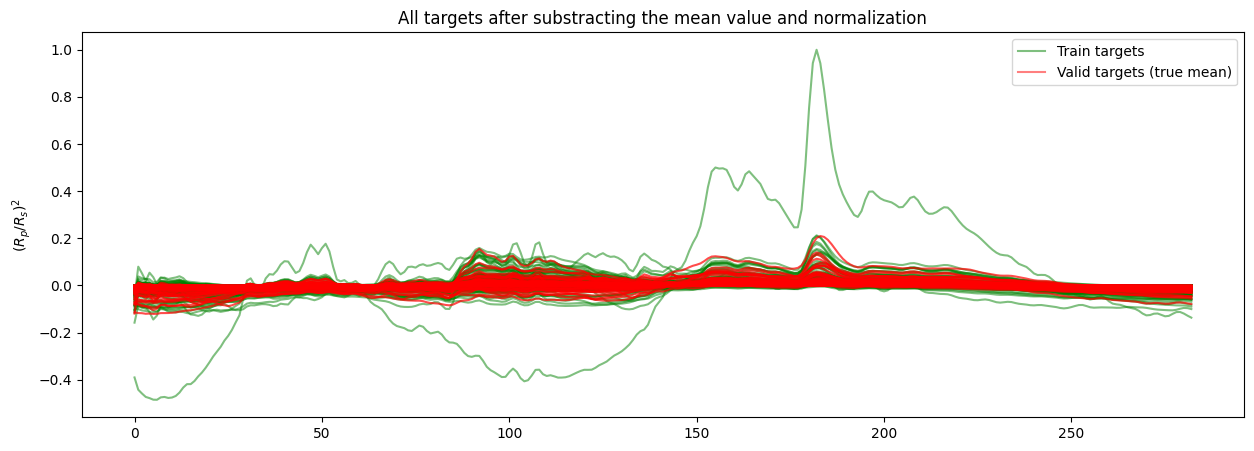

In [22]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) : 
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('All targets after substracting the mean value and normalization')
plt.show()

In [23]:
###### Transpose #####
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape)


(471, 187, 283)


We cut the transit to keep the in-transit. We assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.

In [24]:
##### Substracting the out transit signal #####
def suppress_out_transit (data, ingress, egress) : 
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)


We remove the mean value of the in-transit to get relative data like the targets

In [25]:
###### Substract the mean #####
def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean

train_obs_2d_mean = substract_data_mean(train_obs_in)
valid_obs_2d_mean = substract_data_mean(valid_obs_in)


We use the same normalization as for the targets, i.e. between -1 and 1 centered on zero

In [26]:
##### Normalization dataset #####
def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max) : 
    return data * data_abs_max

train_obs_norm, valid_obs_norm, data_abs_max = data_norm(train_obs_2d_mean, valid_obs_2d_mean)

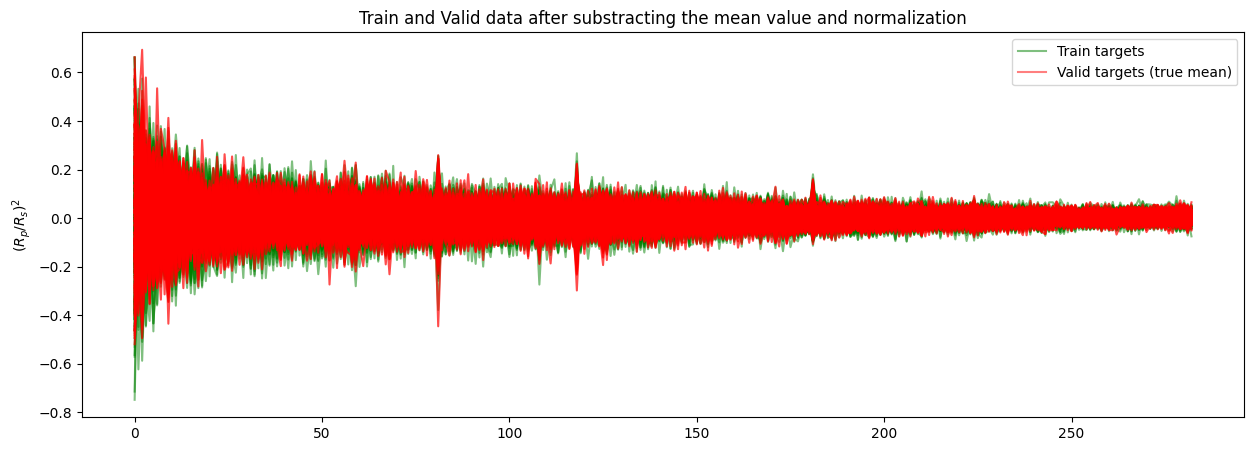

In [27]:
plt.figure(figsize=(15,5))
for i in range (train_obs.shape[0]) :
    plt.plot(wls, train_obs_norm[i,10], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (valid_obs.shape[0]) : 
    plt.plot(wls, valid_obs_norm[i,10], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Train and Valid data after substracting the mean value and normalization')
plt.show()

## Train 2D CNN

In [28]:
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Reshape, Dropout, BatchNormalization, AveragePooling2D
from keras.models import Model
import tensorflow as tf
import numpy as np

## CNN 2 global normalization data
input_obs = Input((40,283,1))
x = Conv2D(32, (3, 1), activation='relu', padding='same')(input_obs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(256, (3, 1), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(128, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(256, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Flatten()(x)
# DNN
x = Dense(700, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
output = Dense(283, activation='linear')(x)

model = Model(inputs=[input_obs], outputs=output)

checkpoint_filepath = 'output/model_2dcnn.keras'
model_ckt2 = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)
model.compile(optimizer=Adam(0.001), loss='mse', metrics=[MeanAbsoluteError()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40, 283, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 283, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 283, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 283, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 283, 64)    │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 283, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 283, 128)   │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 283, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 283, 256)    │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 283, 32)     │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 141, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 141, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 141, 64)     │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 70, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 70, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 35, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 35, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 17, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 700)            │    15,232,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 283)            │       198,383 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,715,019 (59.95 MB)

 Trainable params: 15,714,891 (59.95 MB)

 Non-trainable params: 128 (512.00 B)

In [29]:
history = model.fit(
     x = train_obs_norm,  
     y = train_targets_norm,
     validation_data = (valid_obs_norm, valid_targets_norm),  
     batch_size=32,
     epochs= 250,
     shuffle=True,
     verbose=1,
    callbacks=[model_ckt2]
 )


Epoch 1/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 651ms/step - loss: 0.2075 - mean_absolute_error: 0.2150 - val_loss: 8.2134e-04 - val_mean_absolute_error: 0.0140
Epoch 2/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 7.1193e-04 - mean_absolute_error: 0.0126 - val_loss: 8.0128e-04 - val_mean_absolute_error: 0.0139
Epoch 3/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 7.2022e-04 - mean_absolute_error: 0.0125 - val_loss: 7.7305e-04 - val_mean_absolute_error: 0.0134
Epoch 4/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 8.0388e-04 - mean_absolute_error: 0.0115 - val_loss: 7.5267e-04 - val_mean_absolute_error: 0.0132
Epoch 5/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 6.1614e-04 - mean_absolute_error: 0.0117 - val_loss: 7.4161e-04 - val_mean_absolute_error: 0.0130
Epoch 6/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 6.3093e-04 - mean_absolute_error: 0.0111 - val_loss: 7.3042e-04 - val_mean_absolute_error: 0.0129
Epoch 7/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/s

## Postprocessing and visualisation

We obtain uncertainties on the predictions by computing a MCDropout.

In [30]:
nb_dropout = 5

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test],verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max)
        predictions += [pred]  
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout :
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainity(model, [valid_obs_norm], targets_abs_max, T = nb_dropout)
    
else :

    pred_valid_norm = model.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift = pred_valid
    spectre_valid_shift_std = spectre_valid_shift*0.1


In [31]:
residuals = valid_targets_shift - spectre_valid_shift
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  51.719470332559375 ppm


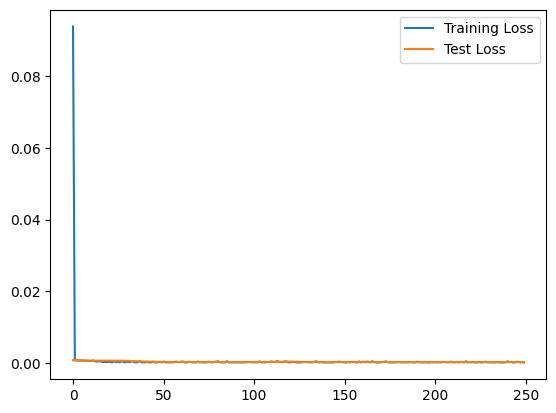

In [32]:
model_wc = load_model(checkpoint_filepath)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

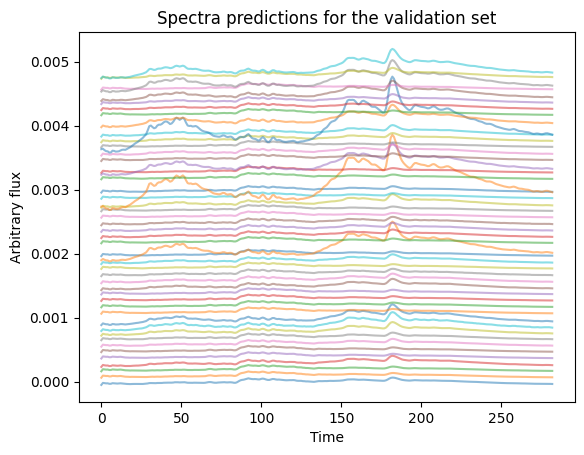

In [34]:
plt.figure()
for i in range (50) : 
    plt.plot(spectre_valid_shift[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set') 
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()


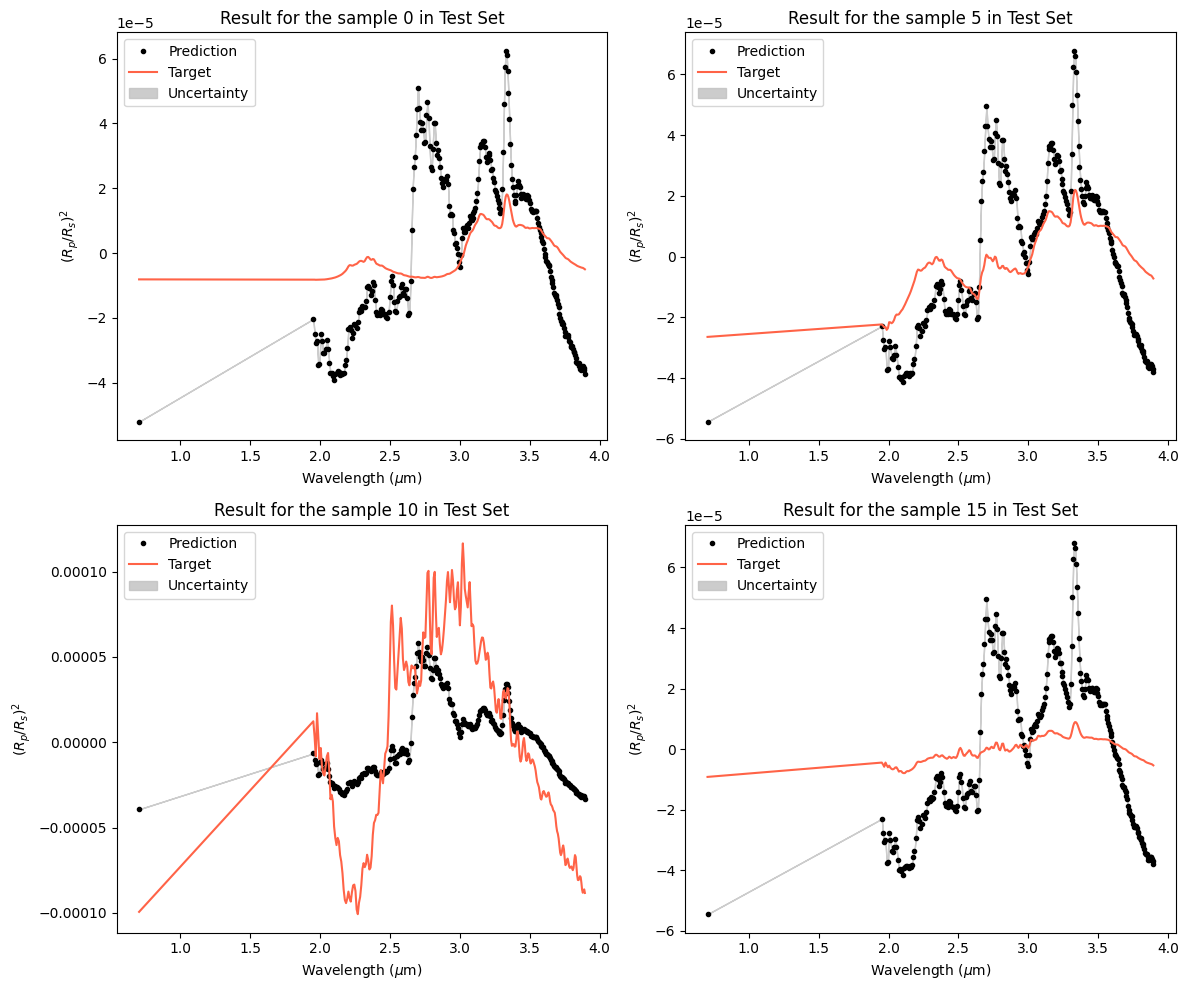

In [35]:
import numpy as np
import matplotlib.pyplot as plt

list_valid_planets = [0, 5, 10, 15]
wavelength = np.loadtxt('/kaggle/input/ariel-data-challenge-2024/wavelengths.csv', skiprows=1, delimiter=',')
uncertainty = spectre_valid_shift_std

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust figsize as needed

# Flatten axes array for easier indexing
axes = axes.flatten()

for idx, i in enumerate(list_valid_planets):
    ax = axes[idx]
    ax.set_title(f'Result for the sample {i} in Test Set')
    ax.plot(wavelength, spectre_valid_shift[i], '.k', label='Prediction')
    ax.plot(wavelength, valid_targets_shift[i], color='tomato', label='Target')
    ax.fill_between(wavelength, spectre_valid_shift[i] - spectre_valid_shift_std[i], spectre_valid_shift[i] + spectre_valid_shift_std[i], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(r'$(R_p/R_s)^2$')
    ax.set_xlabel(r'Wavelength ($\mu$m)')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




# Combine 1D and 2D CNN output for FINAL SPECTRA 

In [36]:
######## ADD THE FLUCTUATIONS TO THE MEAN ########

print(spectre_valid_shift.shape)  # (297, 283)
print(spectre_valid_wc.shape)  # (135, 1)
def add_the_mean (shift, mean) : 
    return shift + mean[:,np.newaxis]

predictions_valid = add_the_mean(spectre_valid_shift,spectre_valid_wc)

predictions_std_valid = np.sqrt(spectre_valid_std_wc[:,np.newaxis]**2 + spectre_valid_shift_std**2)




(202, 283)
(202,)


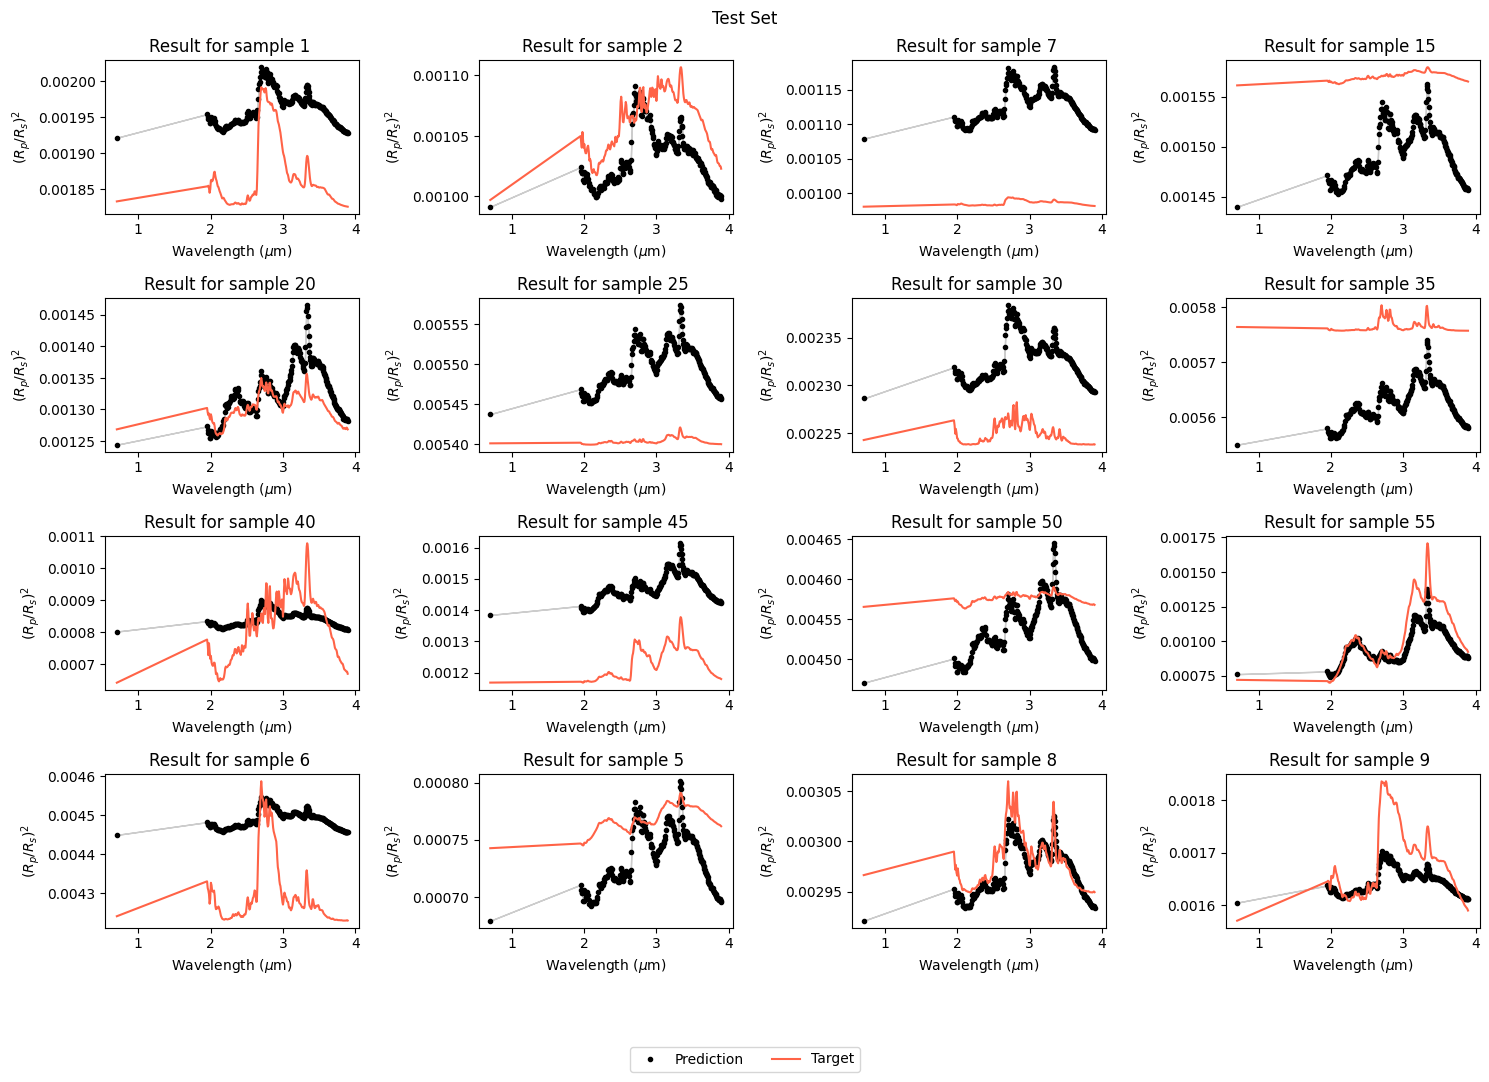

In [37]:
uncertainty = predictions_std_valid

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid[p, :] - uncertainty[p], predictions_valid[p, :] + uncertainty[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Test Set')
plt.tight_layout()
plt.show()


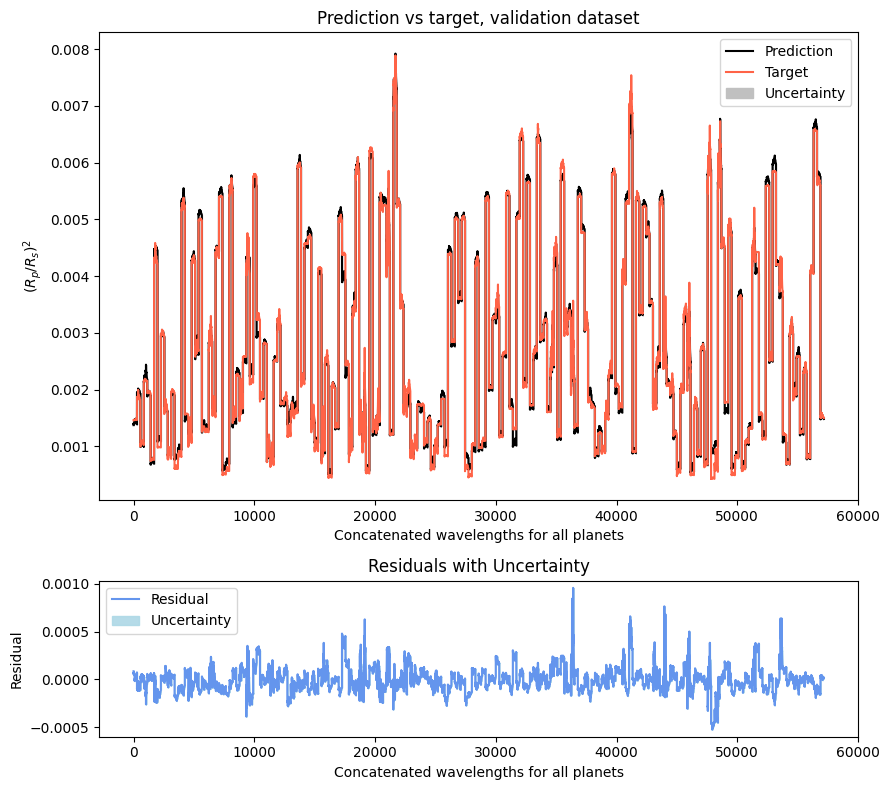

MSE :  123.19312300223737 ppm


In [38]:
######## PLOTS THE RESULT ########
predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std, axis=0)
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)), 
                    predictions_concatenated_plot - uncertainty, 
                    predictions_concatenated_plot + uncertainty, 
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)), 
                    residuals - uncertainty, 
                    residuals + uncertainty, 
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

print('MSE : ',np.sqrt((residuals**2).mean())*1e6, 'ppm')

In [40]:
print(predictions_valid.shape)
print(valid_targets.shape)
import numpy as np
import math

def calculate_gll(y_pred=0,y_true=0,sigmas=1e-5):
    var = sigmas**2
    mse = (y_pred - y_true)**2
    score = -0.5*(np.log(2*math.pi)+np.log(var)+mse/var)
    return round(score.mean(),3)


# L_ref
mn = np.mean(valid_targets, axis=0, keepdims=True)
stdev = np.std(valid_targets, axis=0, keepdims=True)
L_ref = calculate_gll(mn,valid_targets,stdev)
L_ref_mean = round(L_ref.mean(), 3)
print("L_ref_mean = ",L_ref_mean)

# L_ideal
L_ideal = calculate_gll()
L_ideal_mean = round(L_ideal.mean(),3)
print("L_ideal = ",L_ideal_mean)

# L
mn_test = np.mean(predictions_valid, axis=0, keepdims=True)
stdev_test = np.std(predictions_valid, axis=0, keepdims=True)
L = calculate_gll(mn_test, predictions_valid, stdev_test)
L_mean = round(L.mean(), 3)
print("L = ",L_mean)
# (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
score = (L - L_ideal_mean)/(L_ref_mean - L_ideal)
print(score)

(202, 283)
(202, 283)
L_ref_mean =  4.925
L_ideal =  10.594
L =  4.93
0.9991180102310814
